##Import necessary modules first

In [1]:
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/archive.zip'

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [3]:
BASE_DIR = '/content/UTKFace'
age_labels = []
gender_labels = []
image_paths = []

image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
  image_path = os.path.join(BASE_DIR, image)
  img_components = image.split('_')
  age_label = int(img_components[0])
  gender_label = int(img_components[1])

  age_labels.append(age_label)
  gender_labels.append(gender_label)
  image_paths.append(image_path)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [4]:
print(f'Number of age_labels: {len(age_labels)}, Number of gender_labels: {len(gender_labels)},Number of image_paths: {len(image_paths)},')

Number of age_labels: 23708, Number of gender_labels: 23708,Number of image_paths: 23708,


In [5]:
gender_mapping = {
    1: 'Female',
    0: 'Male'
}

In [6]:
import pandas as pd
df = pd.DataFrame()
df['image_path'], df['age'], df['gender'] = image_paths, age_labels, gender_labels

In [7]:
df.head(5)

,image_path,age,gender
0,/content/UTKFace/35_0_3_20170119201340627.jpg....,35,0
1,/content/UTKFace/45_0_4_20170120134936535.jpg....,45,0
2,/content/UTKFace/27_0_3_20170119193411154.jpg....,27,0
3,/content/UTKFace/55_0_0_20170117191559491.jpg....,55,0
4,/content/UTKFace/50_1_0_20170117134105409.jpg....,50,1


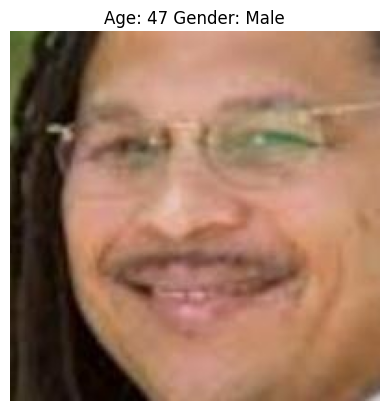

In [8]:
from PIL import Image

rand_index = random.randint(0, len(image_paths))
age = df['age'][rand_index]
gender = df['gender'][rand_index]
IMG = Image.open(df['image_path'][rand_index])
plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
plt.axis('off')
plt.imshow(IMG)

##Age Distribution

<Axes: xlabel='age', ylabel='Density'>

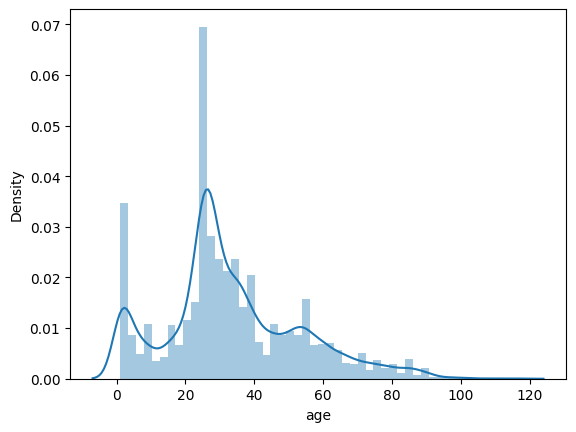

In [9]:
sns.distplot(df['age'])

<Axes: ylabel='count'>

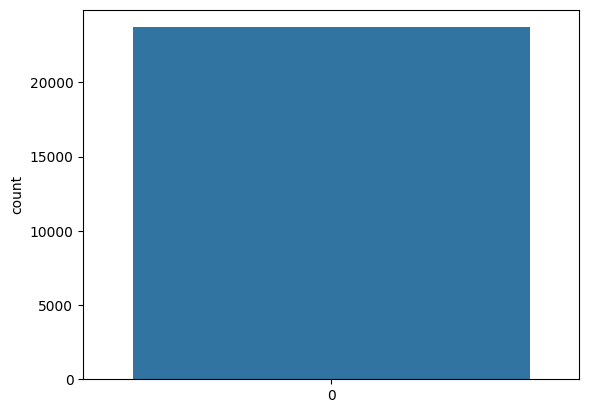

In [10]:
sns.countplot(df['gender'])

In [12]:
plt.figure(figsize=(20,20))
samples = df.iloc[0:16]

for index, sample, age, gender in samples.itertuples():
  plt.subplot(4,4,index+1)
  img = load_img(sample)
  img = np.array(img)
  plt.axis('off')
  plt.title(f'Age: {age}, Gender: {gender_mapping[gender]}')
  plt.imshow(img)

Output hidden; open in https://colab.research.google.com to view.

In [13]:
def extract_image_features(images):
  features= list()

  for image in tqdm(images):
    img = load_img(image, grayscale = True)
    img = img.resize((128,128), Image.ANTIALIAS)
    img = np.array(img)
    features.append(img)

  features = np.array(features)
  features = features.reshape(len(features), 128,128,1)
  return features

In [14]:
X = extract_image_features(df['image_path'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [15]:
X.shape

(23708, 128, 128, 1)

In [16]:
X = X / 255.0

In [17]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [18]:
input_shape = (128, 128, 1)

##Building the Model

In [20]:
inputs = Input(input_shape)
conv_1 = Conv2D(32, kernel_size = (3,3), activation = 'relu')(inputs)
max_1 = MaxPooling2D(pool_size = (2,2))(conv_1)
conv_2 = Conv2D(64, kernel_size = (3,3), activation = 'relu')(max_1)
max_2 = MaxPooling2D(pool_size = (2,2))(conv_2)
conv_3  = Conv2D(128, kernel_size = (3,3), activation = 'relu')(max_2)
max_3 = MaxPooling2D(pool_size = (2,2))(conv_3)
conv_4 = Conv2D(256, kernel_size = (3,3), activation = 'relu')(max_3)
max_4 = MaxPooling2D(pool_size = (2,2))(conv_4)

flatten = Flatten()(max_4)

dense_1 = Dense(256, activation = 'relu')(flatten)
dense_2 = Dense(256, activation = 'relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name = 'gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name = 'age_out')(dropout_2)

model = Model(inputs=[inputs], outputs = [output_1, output_2])

model.compile(loss = ['binary_crossentropy','mae'],
               optimizer = 'adam', metrics=['accuracy'])

##Plot the Model

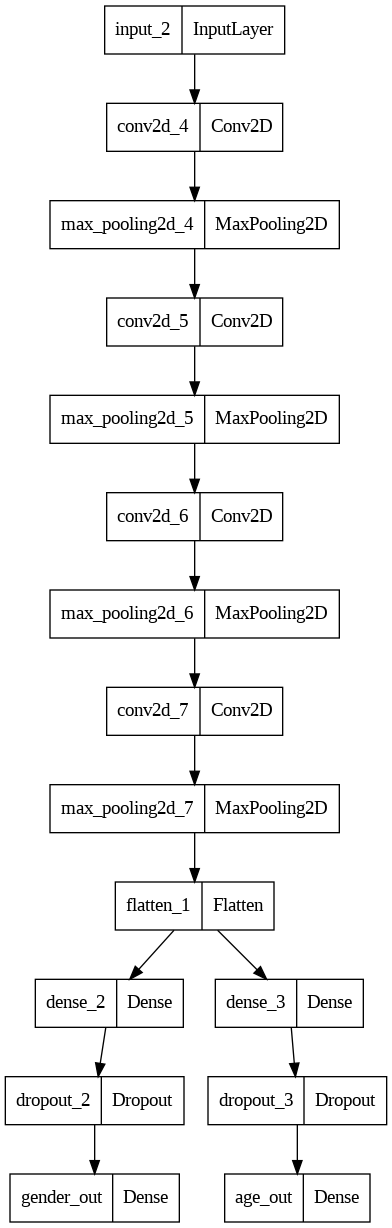

In [21]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [22]:
history = model.fit(x=X, y=[y_gender, y_age],
                    batch_size=32, epochs=50, validation_split=0.2)

Epoch 1/50
593/593 [==============================] - 28s 23ms/step - loss: 15.6064 - gender_out_loss: 0.6615 - age_out_loss: 14.9449 - gender_out_accuracy: 0.5917 - age_out_accuracy: 0.0479 - val_loss: 12.2619 - val_gender_out_loss: 0.5017 - val_age_out_loss: 11.7602 - val_gender_out_accuracy: 0.7478 - val_age_out_accuracy: 0.0432
Epoch 2/50
593/593 [==============================] - 11s 19ms/step - loss: 11.3442 - gender_out_loss: 0.4610 - age_out_loss: 10.8832 - gender_out_accuracy: 0.7824 - age_out_accuracy: 0.0301 - val_loss: 10.1968 - val_gender_out_loss: 0.4300 - val_age_out_loss: 9.7668 - val_gender_out_accuracy: 0.7910 - val_age_out_accuracy: 0.0190
Epoch 3/50
593/593 [==============================] - 11s 19ms/step - loss: 9.7665 - gender_out_loss: 0.3920 - age_out_loss: 9.3746 - gender_out_accuracy: 0.8166 - age_out_accuracy: 0.0174 - val_loss: 9.0829 - val_gender_out_loss: 0.3575 - val_age_out_loss: 8.7254 - val_gender_out_accuracy: 0.8286 - val_age_out_accuracy: 0.0082
Epo

## plot results for gender

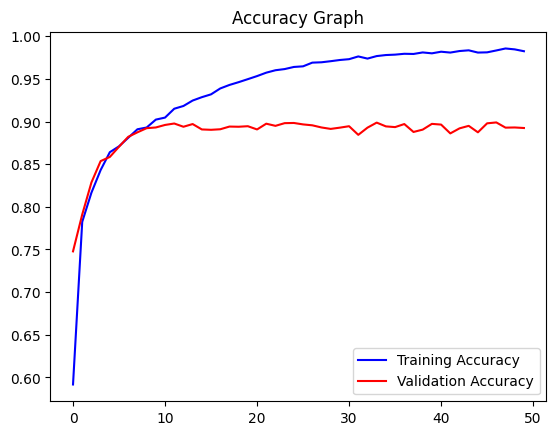

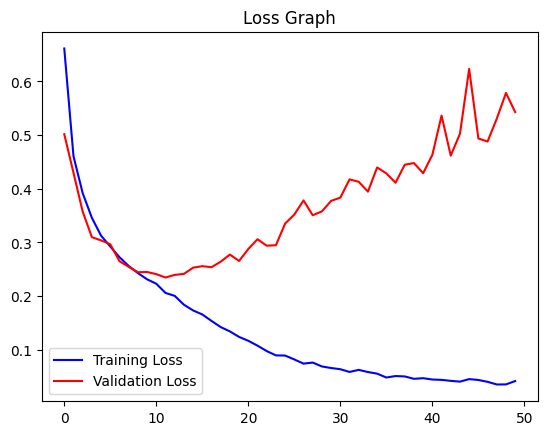

In [23]:

acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

## plot results for age

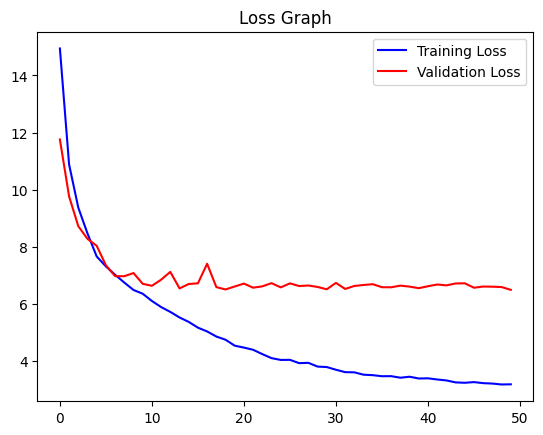

In [24]:
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

#Predictions

In [25]:
def get_image_features(image):
  img = load_img(image, grayscale=True)
  img = img.resize((128, 128), Image.ANTIALIAS)
  img = np.array(img)
  img = img.reshape(1, 128, 128, 1)
  img = img / 255.0
  return img

1/1 [==============================] - 1s 758ms/step


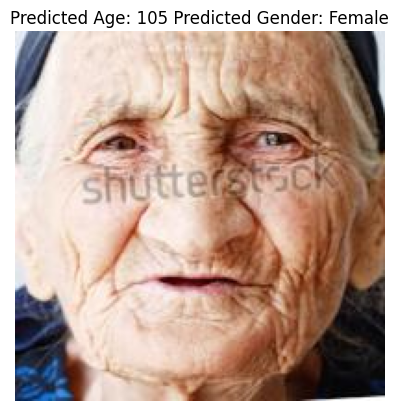

In [27]:
img_to_test = '/content/crop_part1/100_1_0_20170110183726390.jpg.chip.jpg'
features = get_image_features(img_to_test)
pred = model.predict(features)
gender = gender_mapping[round(pred[0][0][0])]
age = round(pred[1][0][0])

plt.title(f'Predicted Age: {age} Predicted Gender: {gender}')
plt.axis('off')
plt.imshow(np.array(load_img(img_to_test)))

In [29]:
BASE_DIR_1 = '/content/crop_part1'
age_labels_1 = []
gender_labels_1 = []
image_paths_1 = []

image_filenames_1 = os.listdir(BASE_DIR_1)
random.shuffle(image_filenames_1)

for image in tqdm(image_filenames_1):
  image_path_1 = os.path.join(BASE_DIR_1, image)
  img_components_1 = image.split('_')
  age_label_1 = int(img_components_1[0])
  gender_label_1 = int(img_components_1[1])

  # Append the image_path, age_label, and gender_label
  age_labels_1.append(age_label_1)
  gender_labels_1.append(gender_label_1)
  image_paths_1.append(image_path_1)

  0%|          | 0/9780 [00:00<?, ?it/s]

In [30]:
age_labels_1[:5]

[45, 23, 4, 29, 14]

45
0


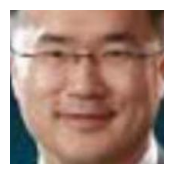

23
1


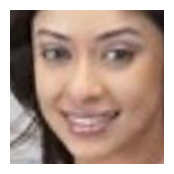

4
1


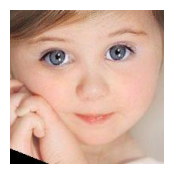

29
1


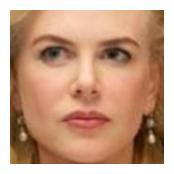

14
1


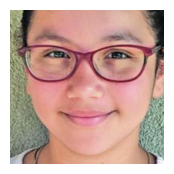

70
1


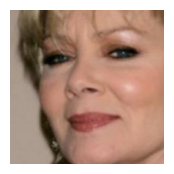

2
1


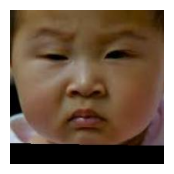

1
0


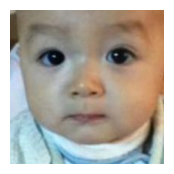

6
1


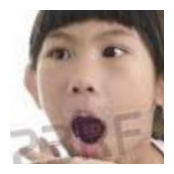

2
1


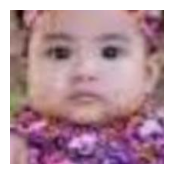

In [31]:
import cv2
import matplotlib.pyplot as plt

# Load and display the first 10 images
for i in range(10):
    image_path_1 = image_paths_1[i]
    image = cv2.imread(image_path_1)

    # Display the image using Matplotlib
    plt.figure(figsize=(2, 2))
    print(age_labels_1[i])
    print(gender_labels_1[i])
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [32]:
image_paths_1[0]

'/content/crop_part1/45_0_2_20170109013208873.jpg.chip.jpg'

1/1 [==============================] - 0s 41ms/step
Actual Age: 45 Actual Gender: 0


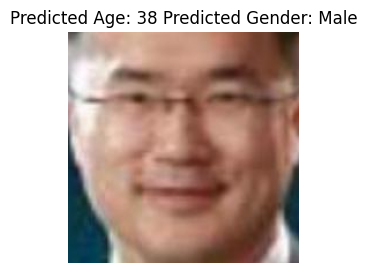

1/1 [==============================] - 0s 31ms/step
Actual Age: 23 Actual Gender: 1


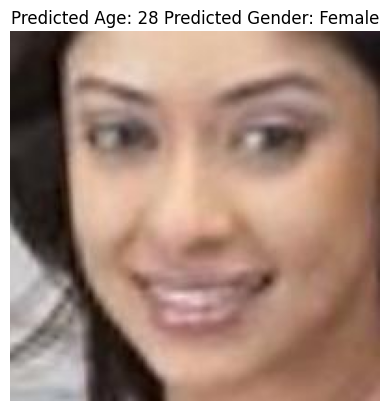

1/1 [==============================] - 0s 36ms/step
Actual Age: 4 Actual Gender: 1


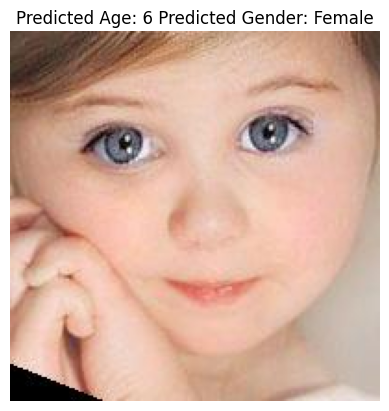

1/1 [==============================] - 0s 44ms/step
Actual Age: 29 Actual Gender: 1


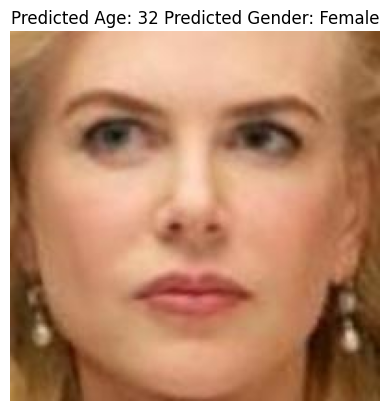

1/1 [==============================] - 0s 18ms/step
Actual Age: 14 Actual Gender: 1


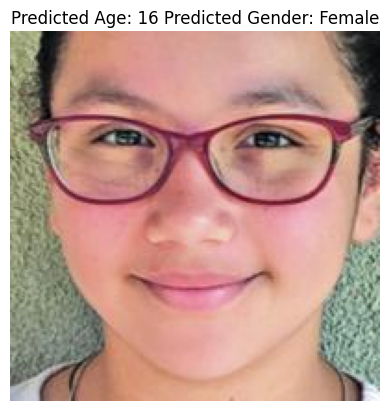

1/1 [==============================] - 0s 23ms/step
Actual Age: 70 Actual Gender: 1


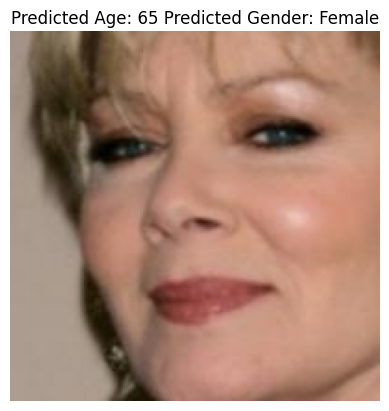

1/1 [==============================] - 0s 20ms/step
Actual Age: 2 Actual Gender: 1


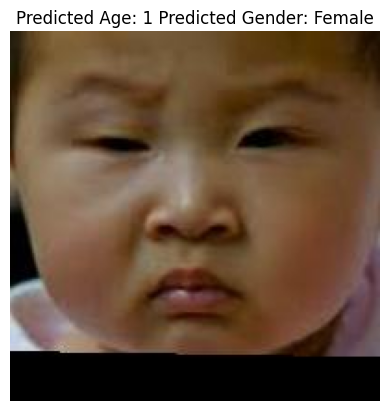

1/1 [==============================] - 0s 27ms/step
Actual Age: 1 Actual Gender: 0


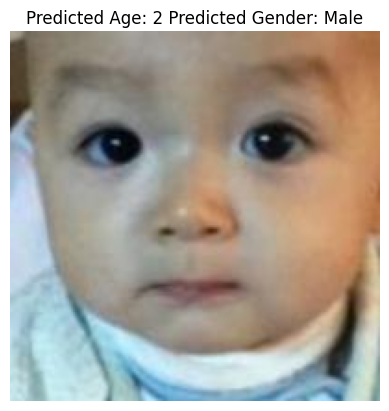

1/1 [==============================] - 0s 19ms/step
Actual Age: 6 Actual Gender: 1


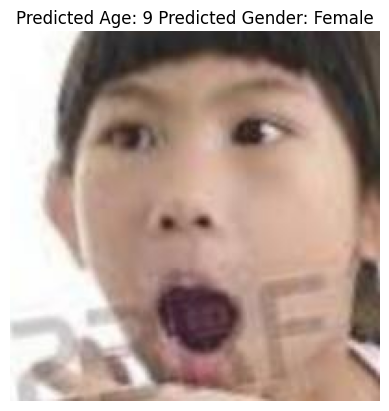

1/1 [==============================] - 0s 18ms/step
Actual Age: 2 Actual Gender: 1


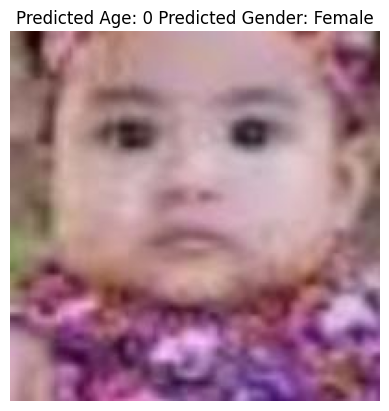

In [33]:
plt.figure(figsize=(3,3))
for i in range(10):
    img_to_test = image_paths_1[i]  # Use the current index 'i' to select a different image
    plt.imshow(np.array(load_img(img_to_test)))
    features = get_image_features(img_to_test)
    pred = model.predict(features)
    gender = gender_mapping[round(pred[0][0][0])]
    age = round(pred[1][0][0])

    plt.title(f'Predicted Age: {age} Predicted Gender: {gender}')
    print(f'Actual Age: {age_labels_1[i]} Actual Gender: {gender_labels_1[i]}')
    plt.axis('off')
    plt.show()